In [7]:
%pip install kagglehub pandas matplotlib tqdm nltk torch numpy transformers

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [8]:
from tqdm import tqdm
import re

import random
import os
import numpy as np

import torch

import kagglehub
import matplotlib.pyplot as plt
import pandas as pd

In [9]:
tqdm.pandas()

In [10]:
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

## Датасет

Скачаем наш датасет и проанализируем его

In [11]:
%%time
ds_path = kagglehub.dataset_download("kamaruladha/mental-disorders-identification-reddit-nlp")
ds_path

CPU times: user 46.5 ms, sys: 6 ms, total: 52.5 ms
Wall time: 408 ms


'/Users/sasha/.cache/kagglehub/datasets/kamaruladha/mental-disorders-identification-reddit-nlp/versions/2'

In [12]:
dataset = pd.read_csv(f'{ds_path}/mental_disorders_reddit.csv')
dataset.head()

,title,selftext,created_utc,over_18,subreddit
0,Life is so pointless without others,Does anyone else think the most important part...,1650356960,False,BPD
1,Cold rage?,Hello fellow friends 😄\n\nI'm on the BPD spect...,1650356660,False,BPD
2,I don’t know who I am,My [F20] bf [M20] told me today (after I said ...,1650355379,False,BPD
3,HELP! Opinions! Advice!,"Okay, I’m about to open up about many things I...",1650353430,False,BPD
4,help,[removed],1650350907,False,BPD


Рассмотри его подробнее. В качестве класса выступает поле `subreddit`, идентифицирующее ментальное заболевание. Посмотрим на его распределение в рамках датасета

In [13]:
dataset.rename(columns={'subreddit': 'class'}, inplace=True)

In [14]:
def show_dataset_info():
    class_counts = dataset['class'].value_counts()
    print(class_counts)

    plt.figure(figsize=(8, 6))
    plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%')
    plt.title('Распределение классов')

class
BPD              241116
Anxiety          173990
depression       156972
mentalillness     53232
bipolar           51112
schizophrenia     25365
Name: count, dtype: int64


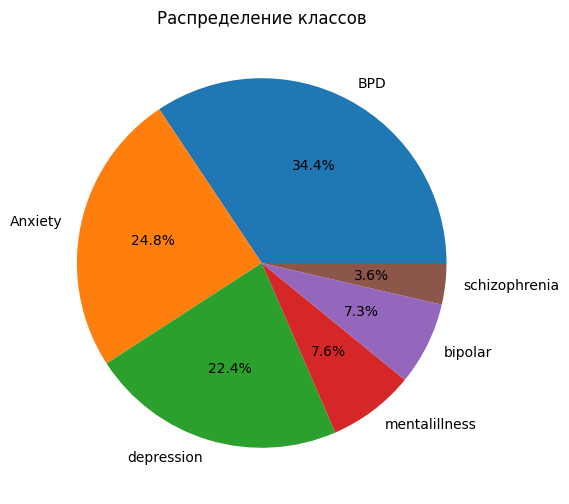

In [15]:
show_dataset_info()

### Предобработка

В описании датасета сказано:

> The dataset is field with "troll" posts that would only disturb the learning process of the model. The troll post may look something like this ("I AM IN YOUR WALLS/FLOORBOARD/CEILING/etc). The purpose of these troll posts are still unknown. Thus, heavy preprocessing is needed to ensure that the model is only fed with high quality data.

Поэтому займемся его предобработкой. Помимо удаления "троллинговых" постов, стоит еще заняться очисткой коротких текстов, чтобы наши модели могли качественно обучиться.

In [16]:
# Очищает удаленные записи в датасете. Такие посты помечены как [removed]
clean_removed_mask = dataset.apply(lambda row: row['selftext'] != '[removed]' and row['title'] != '[removed]', axis=1)
dataset = dataset[clean_removed_mask]
dataset = dataset.dropna()

In [17]:
# Удаляем лишний класс
dataset = dataset[dataset['class'] != 'mentalillness']

In [18]:
dataset = dataset[dataset.apply(lambda row: 'I AM IN YOUR WALLS' not in row['selftext'], axis=1)]

In [19]:
# Удаляем короткие посты.
dataset = dataset[dataset.apply(lambda row: len(row['selftext']) > 150, axis=1)]

Для дальнейшего упрощения обучения моделей "смержим" два столбца (`title` и `selftext`) в один. Заодно удалим лишние столбцы.

In [20]:
dataset['text'] = dataset['title'] + ' ' + dataset['selftext']
dataset.drop(['selftext', 'title', 'created_utc', 'over_18'], axis=1, inplace=True)

In [21]:
dataset.head()

,class,text
0,BPD,Life is so pointless without others Does anyon...
1,BPD,Cold rage? Hello fellow friends 😄\n\nI'm on th...
2,BPD,I don’t know who I am My [F20] bf [M20] told m...
3,BPD,"HELP! Opinions! Advice! Okay, I’m about to ope..."
5,BPD,My ex got diagnosed with BPD Without going int...


В датасете также встречаются слова с сокращениями (`I've`, `gotta`, `can't`, etc.). По-хорошему их тоже следует очистить

In [22]:
abbr_dict = {
    "'cause": "because",
    "ain't": "am not",
    "can't": "can not",
    "cannot": "can not",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesnt": "does not",
    "dont": "do not",
    "gimme": "give me",
    "gotta": "got to",
    "hadn't": "had not",
    "hadnt": "had not",
    "hasn't": "has not",
    "hasnt": "has not",
    "haven't": "have not",
    "havent": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "here's": "here is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'm": "i am",
    "i'll": "i will",
    "i've": "i have",
    "i ve": "i have",
    "imma": "i am going to",
    "isn't": "is not",
    "it'll": "it will",
    "it's": "it is",
    "lemme": "let me",
    "let's": "let us",
    "not've": "not have",
    "shouldn't": "should not",
    "she'll": "she will",
    "she's": "she is",
    "that's": "that is",
    "there's": "there is",
    "there're": "there are",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "wasnt": "was not",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "werent": "were not",
    "what's": "what is",
    "what're": "what are",
    "when's": "when is",
    "when're": "when are",
    "where's": "where is",
    "where're": "where are",
    "who's": "who is",
    "who're": "who are",
    "who've": "who have",
    "won't": "will not",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
}

In [23]:
def replace_abbreviations(text):
    # Заменим "don't" на "do not"
    text = re.sub(r'\bdon t\b', 'do not', text, flags=re.IGNORECASE)
    # Заменим "i ve" на "i have"
    text = re.sub(r'\bi ve\b', 'i have', text, flags=re.IGNORECASE)

    # Заменим аббревиатуры
    for word in text.split():
        if word.lower() in abbr_dict:
            text = re.sub(r'\b{}\b'.format(word), abbr_dict[word.lower()], text, flags=re.IGNORECASE)

    return text

In [24]:
dataset['text'] = dataset['text'].progress_apply(replace_abbreviations)

100%|██████████| 488801/488801 [00:51<00:00, 9411.62it/s] 


В датасете также встечались эмодзи, их тоже следует удалить

In [25]:
dataset['text'] = dataset['text'].apply(lambda x: str(x).encode('ascii', 'ignore').decode('ascii'))

Посмотрим теперь вновь на сбалансированность нашего датасета.

class
BPD              193717
Anxiety          147897
depression       107003
bipolar           30741
schizophrenia      9443
Name: count, dtype: int64


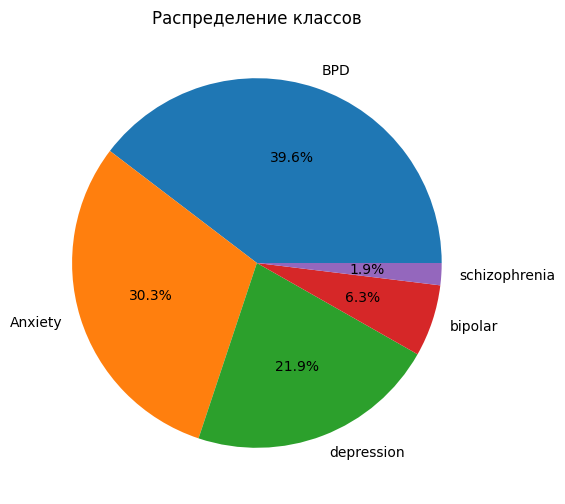

In [26]:
show_dataset_info()

Видно, что данных по шизофрении и биполярке мало. Их можно разбавить, сгенерировав похожие по смыслу данные. Заодно обрезать размер нашего датасета до 15 000 записей на каждый класс — такого объема точно хватит для качественного
результата, а также мы сократим время, требуемое на обучение моделей и генерацию аугментаций.

In [27]:
dataset = dataset.groupby('class', group_keys=False).apply(lambda x: x.sample(n=min(len(x), 15000), random_state=42), include_groups=True).reset_index(drop=True)

/var/folders/3y/jpw0zmz931vf555w9z3n5pwr0000gn/T/ipykernel_4581/1770838378.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dataset = dataset.groupby('class', group_keys=False).apply(lambda x: x.sample(n=min(len(x), 15000), random_state=42), include_groups=True).reset_index(drop=True)


In [28]:
%pip install nlpaug wordnet

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [29]:
import nlpaug.augmenter.word as naw
import nlpaug.flow as naf

In [30]:
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /Users/sasha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/sasha/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/sasha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [31]:
aug_flow = naf.Sequential([
    naw.ContextualWordEmbsAug(
        model_path="google-bert/bert-base-cased",
        aug_p=0.2,
    ),
    naw.SynonymAug(aug_src='wordnet', aug_p=0.3, aug_max=10)
])

The following layers were not sharded: bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.token_type_embeddings.weight, bert.embeddings.LayerNorm.weight, cls.predictions.transform.dense.weight, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.query.weight, cls.predictions.transform.LayerNorm.weight, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.self.key.bias, bert.embeddings.LayerNorm.bias, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.encoder.layer.*.intermediate.dense.bias, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, cls.predictions.decoder.bias, cls.predictions.transform.dense.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.value.weight, cls.predictions.transform.Lay

In [33]:
example_text_to_change = dataset['text'].sample(1, ignore_index=True)[0]
augmented_text = aug_flow.augment(
    example_text_to_change,
)[-1]
print('BEFORE:', example_text_to_change)
print('')
print('AFTER:', augmented_text)

BEFORE: Can i take my Xanax right now?          i am suffering from anxiety for 1+ year. Last 2 months was nearly non-anxious times. Right now i am trembling, my heart rate is slightly high and I can not breathe properly. I just met with my friends and it started to happen at there and i am still experiencing. I don't have a mood to deal with it right now, can I take .25? (.25 is what my doc suggest also sorry I can not correct my grammars rn i am also confused.)The thing that makes me uncomfortable I have not took Xanax in last 4-5 months. Any opinions?

AFTER: Can i take an Alprazolam right now? i am suffering from anxiety for 0 + 0. Last 2 year was nearly non - anxious times. Right now i be trembling, its heart and soul rate feeling slightly high and also can not breathe properly. I just met with my friends and it started to happen at there and i am still experiencing. I don ' t have a mood to deal with it right now, can Ace take. twenty five? (. 25 is what my doc suggest also is I 

class
Anxiety          15000
BPD              15000
bipolar          15000
depression       15000
schizophrenia     9443
Name: count, dtype: int64


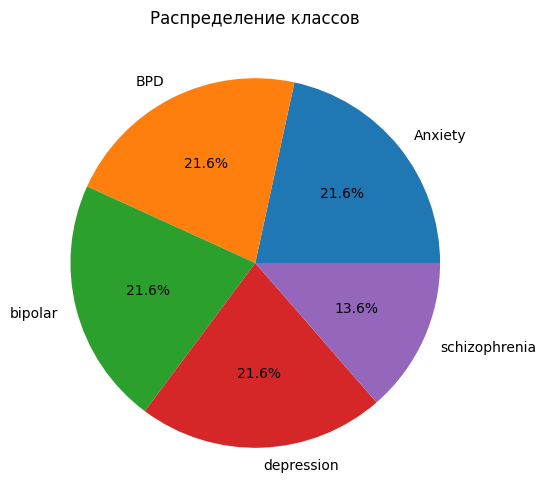

In [34]:
show_dataset_info()

In [64]:
def generate_text_augmentations(target_class='schizophrenia'):
    assert target_class in ['schizophrenia']

    class_texts = dataset[dataset['class'] == target_class]['text'].dropna().tolist()
    target_n = 15_000
    augmented_texts = []
    needed_n = target_n - len(class_texts)

    with tqdm(total=needed_n) as pbar:
        while len(augmented_texts) < needed_n:
            chosen_text = random.choice(class_texts)

            new_augments = aug_flow.augment(chosen_text, n=min(100, needed_n))
            valid_augments = []
            for aug in new_augments:
                valid_augments.append(aug)

            augmented_texts.extend(valid_augments)
            pbar.update(len(new_augments))

    return augmented_texts

In [65]:
%%time
schi_aug_data = generate_text_augmentations()

5600it [31:05,  3.00it/s]                          

CPU times: user 1h 7min 58s, sys: 8min 7s, total: 1h 16min 6s
Wall time: 31min 5s


In [71]:
schi_aug_df = pd.DataFrame({
    'text': schi_aug_data,
    'class': 'schizophrenia'
})

dataset = pd.concat([dataset, schi_aug_df], ignore_index=True)

In [74]:
dataset.to_csv('datasets/augmented_dataset.csv', index=False)